In [ ]:
!python -m spacy download en_core_web_lg

In [5]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
import pandas as pd 
import numpy as np

In [5]:
df = pd.read_csv('./drive/MyDrive/review_50k.csv', index_col=0)
df.head()

,text,label
0,"If you decide to eat here, just be aware it is...",2
1,I've taken a lot of spin classes over the year...,1
2,Family diner. Had the buffet. Eclectic assortm...,2
3,"Wow! Yummy, different, delicious. Our favo...",1
4,Cute interior and owner (?) gave us tour of up...,1


In [6]:
df = df[df['label']!=2]
df['pos'] = ''
df

,text,label
1,I've taken a lot of spin classes over the year...,1
3,"Wow! Yummy, different, delicious. Our favo...",1
4,Cute interior and owner (?) gave us tour of up...,1
5,I am a long term frequent customer of this est...,0
6,Loved this tour! I grabbed a groupon and the p...,1
...,...,...
49994,I know I'm one of the few who seem to have had...,0
49995,Came here first for breakfast and had their yu...,1
49996,Food was good. I had a decent breakfast but no...,0
49998,"Best shrimp on the beach! Steamed to order, d...",1


In [7]:
length = [len(t.split()) for t in df['text']]

In [8]:
import seaborn as sb

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


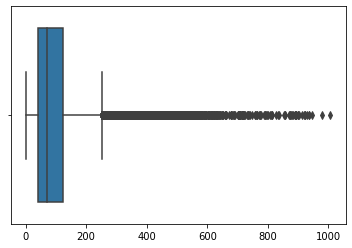

In [9]:
sb.boxplot(length)

In [10]:
lth = pd.Series(length)
lth.describe()

count    44323.000000
mean        98.656251
std         91.514822
min          1.000000
25%         40.000000
50%         70.000000
75%        125.000000
max       1006.000000
dtype: float64

In [11]:
a = [i for i in length if i>256]

In [12]:
len(a)

2601

In [13]:
# Above is distribution of number of words in each review, to decide the MAXLEN for model 
# (i.e. if review is longer thaan 256 words, we split it into several reviews with the same label)

In [10]:
EMBEDDING_DIM = 100
MAXLEN = 256
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
SPLIT = 0.2

In [16]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from langdetect import detect
oov_words = []
lang_list = []
def preprocess(df):
  for index, row in df.iterrows():
    text = row['text']
    try:
      lang = detect(text)
    except:
      lang_list.append(text)
      df.drop([index], inplace=True)
      continue
        
    if lang!='en':
      lang_list.append(text)
      df.drop([index], inplace=True)
    else:
      doc = nlp(text)
      clean_token = []
      pos = []
      text_part = []
      pos_part = []
      length = 0
      for token in doc:
        if length >= MAXLEN:
          # print(index, 'start_new')
          text_part.append(' '.join(clean_token))
          pos_part.append(' '.join(pos))
          clean_token = []
          pos = []
          length = 0
        if token.is_oov:
          oov_words.append(token.text)
        elif token.is_stop == False and token.is_punct == False:
          clean_token.append(token.lower_)
          pos.append(token.pos_)
          length += 1
      if clean_token:
        text_part.append(' '.join(clean_token))
        pos_part.append(' '.join(pos))
      df.at[index, 'text'] = text_part
      df.at[index, 'pos'] = pos_part

In [22]:
preprocess(df)

In [23]:
oov_series = pd.Series(oov_words)
oov_series.unique()

array(['\n\n', 'duckfat', 'frenchfries', ..., 'chcago', 'Chicharrone',
       '.Come'], dtype=object)

In [ ]:
lang_list

In [24]:
new_df = df.explode(['text', 'pos']).reset_index(drop=True)

In [25]:
new_df.to_csv('./drive/MyDrive/cleaned.csv')

In [32]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44410 entries, 0 to 44409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44410 non-null  object
 1   label   44410 non-null  int64 
 2   pos     44410 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [7]:
df = pd.read_csv('./drive/MyDrive/cleaned.csv', index_col=0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44410 entries, 0 to 44409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44410 non-null  object
 1   label   44410 non-null  int64 
 2   pos     44410 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=SPLIT, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=SPLIT, random_state=42)
train_list = list(train_df['text'])
train_pos_list = list(train_df['pos'])
train_labels = np.array(list(train_df['label']))

val_list = list(val_df['text'])
val_pos_list = list(val_df['pos'])
val_labels = np.array(list(val_df['label']))

test_list = list(test_df['text'])
test_pos_list = list(test_df['pos'])
test_labels = np.array(list(test_df['label']))

In [12]:
train_df.head()

,text,label,pos
31914,going neptune location 2 years katrina great m...,1,VERB PROPN NOUN NUM NOUN PROPN ADJ VERB VERB A...
18064,rude rude rude dealt service center twice orig...,0,ADJ ADJ ADJ VERB NOUN NOUN ADV ADV VERB PROPN ...
25157,venue ridiculous people let crappy acoustics m...,0,NOUN ADJ NOUN VERB ADJ NOUN ADV VERB NOUN
28972,sushi experience philadelphia chinatown intere...,1,NOUN NOUN PROPN NOUN ADJ NOUN NOUN VERB NOUN A...
7689,reservations night started w florida calamari ...,1,NOUN NOUN VERB DET PROPN PROPN PROPN NOUN NOUN...


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(oov_token = OOV_TOKEN)
tokenizer.fit_on_texts(train_list)
pos_tokenizer = Tokenizer(oov_token = OOV_TOKEN)
pos_tokenizer.fit_on_texts(train_pos_list)

Global variable `VOCAB_SIZE` defined here

In [14]:
word_index = tokenizer.word_index
pos_index = pos_tokenizer.word_index
VOCAB_SIZE = len(word_index)
POS_SIZE = len(pos_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")
print()
print(f"Vocabulary contains {POS_SIZE} POS tags\n")
print("<OOV> token included in POS" if "<OOV>" in pos_index else "<OOV> token NOT included in POS")
print(f"\nindex of word 'noun' should be {pos_index['noun']}")

Vocabulary contains 31857 words

<OOV> token included in vocabulary

index of word 'i' should be 1480

Vocabulary contains 19 POS tags

<OOV> token included in POS

index of word 'noun' should be 2


In [15]:
# Checking the tokenizer is fit correctly on POS tags

In [16]:
allPOS = pd.Series(' '.join(train_pos_list).split())
allPOS.unique()

array(['VERB', 'PROPN', 'NOUN', 'NUM', 'ADJ', 'ADV', 'SYM', 'DET',
       'SCONJ', 'INTJ', 'ADP', 'CCONJ', 'AUX', 'PUNCT', 'PRON', 'X',
       'PART', 'SPACE'], dtype=object)

In [17]:
pos_index

{'<OOV>': 1,
 'noun': 2,
 'verb': 3,
 'adj': 4,
 'propn': 5,
 'adv': 6,
 'num': 7,
 'adp': 8,
 'intj': 9,
 'sym': 10,
 'aux': 11,
 'sconj': 12,
 'x': 13,
 'part': 14,
 'cconj': 15,
 'pron': 16,
 'det': 17,
 'punct': 18,
 'space': 19}

In [18]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """        
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, padding=padding, truncating=truncating, maxlen=maxlen)
    
    return pad_trunc_sequences

In [19]:
train_pad_trunc_seq = seq_pad_and_trunc(train_list, tokenizer, PADDING, TRUNCATING, MAXLEN)
train_pos_pad_trunc_seq = seq_pad_and_trunc(train_pos_list, pos_tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_list, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pos_pad_trunc_seq = seq_pad_and_trunc(val_pos_list, pos_tokenizer, PADDING, TRUNCATING, MAXLEN)
test_pad_trunc_seq = seq_pad_and_trunc(test_list, tokenizer, PADDING, TRUNCATING, MAXLEN)
test_pos_pad_trunc_seq = seq_pad_and_trunc(test_pos_list, pos_tokenizer, PADDING, TRUNCATING, MAXLEN)

In [20]:
print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (28422, 256)

Padded and truncated validation sequences have shape: (7106, 256)


In [21]:
# Define path to file containing the embeddings
GLOVE_FILE = './drive/MyDrive/data/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [22]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
def create_model(vocab_size, pos_size, embedding_dim, maxlen, embeddings_matrix):
    """
    Creates a binary sentiment classifier model
    
    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        pos_size (int): size of the POS list for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings
    
    Returns:
        model (tf.keras Model): the sentiment classifier model
    """
    text_input = tf.keras.layers.Input(shape=(maxlen,))
    text_embed = tf.keras.layers.Embedding(vocab_size+1, embedding_dim, weights=[embeddings_matrix], trainable=False)(text_input)
    pos_input = tf.keras.layers.Input(shape=(maxlen,))
    pos_embed = tf.keras.layers.Embedding(pos_size+1, embedding_dim)(pos_input)
    cat = tf.keras.layers.Concatenate(axis=1)([text_embed, pos_embed])
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, return_sequences=True))(cat)
    x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(x)
    x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(24, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[text_input, pos_input], outputs=[out])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model

In [24]:
model = create_model(VOCAB_SIZE, POS_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

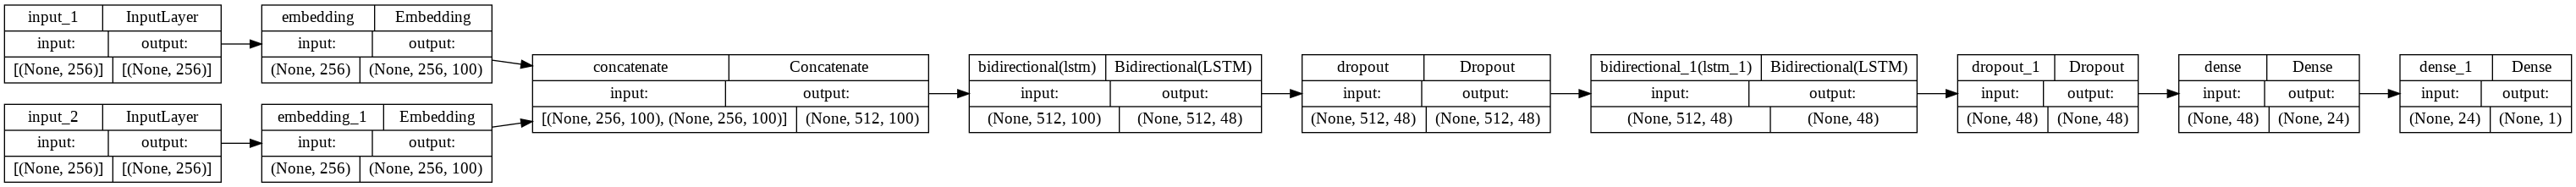

In [25]:
import keras
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [26]:
# Create your untrained model
model = create_model(VOCAB_SIZE, POS_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

# Train the model and save the training history
history = model.fit([train_pad_trunc_seq, train_pos_pad_trunc_seq],
                    train_labels, 
                    epochs=20, 
                    validation_data=([val_pad_trunc_seq, val_pos_pad_trunc_seq], val_labels),
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience=5)])

Epoch 1/20
889/889 [==============================] - 63s 61ms/step - loss: 0.3590 - accuracy: 0.8524 - val_loss: 0.2381 - val_accuracy: 0.9099
Epoch 2/20
889/889 [==============================] - 49s 55ms/step - loss: 0.2542 - accuracy: 0.9069 - val_loss: 0.2014 - val_accuracy: 0.9232
Epoch 3/20
889/889 [==============================] - 48s 54ms/step - loss: 0.2233 - accuracy: 0.9193 - val_loss: 0.2541 - val_accuracy: 0.9174
Epoch 4/20
889/889 [==============================] - 49s 55ms/step - loss: 0.2081 - accuracy: 0.9259 - val_loss: 0.1959 - val_accuracy: 0.9325
Epoch 5/20
889/889 [==============================] - 48s 54ms/step - loss: 0.1914 - accuracy: 0.9312 - val_loss: 0.2274 - val_accuracy: 0.9158
Epoch 6/20
889/889 [==============================] - 52s 58ms/step - loss: 0.1826 - accuracy: 0.9354 - val_loss: 0.1879 - val_accuracy: 0.9292
Epoch 7/20
889/889 [==============================] - 48s 54ms/step - loss: 0.1655 - accuracy: 0.9399 - val_loss: 0.1868 - val_accuracy:

In [27]:
loss, acc = model.evaluate([test_pad_trunc_seq, test_pos_pad_trunc_seq], test_labels, verbose=2)

278/278 - 6s - loss: 0.1769 - accuracy: 0.9402 - 6s/epoch - 21ms/step


In [28]:
model.save('./drive/MyDrive/data/saved_model/senti_pos_model.h5')

In [29]:
new_model = tf.keras.models.load_model('./drive/MyDrive/data/saved_model/senti_pos_model.h5')

# Show the model architecture
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 256, 100)     3185800     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 256, 100)     2000        ['input_4[0][0]']                
                                                                                            